In [1]:
import tensorflow as tf

In [2]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.5/129.5 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 23.0 MB/s eta 0:00:00


In [3]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


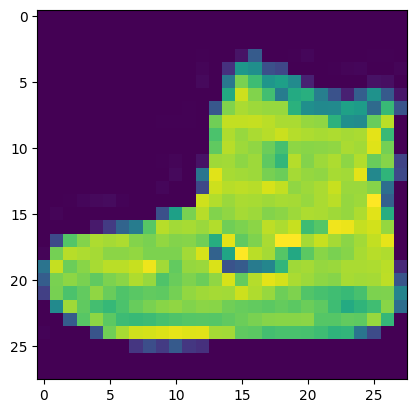

In [4]:
import matplotlib.pyplot as plt

plt.imshow(X_train[0])

In [5]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [6]:
def build_model(hp):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))

  hp_activation = hp.Choice('activation', values=['relu', 'swish', 'gelu'])
  hp_layer_1 = hp.Int('layer_1', min_value=1, max_value=1000, step=100)
  hp_layer_2 = hp.Int('layer_2', min_value=1, max_value=1000, step=100)
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.add(tf.keras.layers.Dense(units=hp_layer_1, activation=hp_activation))
  model.add(tf.keras.layers.Dense(units=hp_layer_2, activation=hp_activation))
  model.add(tf.keras.layers.Dense(10, activation='softmax'))

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])

  return model

In [7]:
import keras_tuner as kt

tuner = kt.Hyperband(build_model,
                     objective=kt.Objective("val_accuracy", direction="max"),
                     max_epochs=10,
                     factor=3,
                     directory='model',
                     project_name='fashion_mnist')

Using TensorFlow backend


In [8]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

In [9]:
tuner.search(X_train, y_train, epochs=10, validation_split=0.2, callbacks=[stop_early])

Trial 30 Complete [00h 01m 04s]
val_accuracy: 0.3243333399295807

Best val_accuracy So Far: 0.8943333625793457
Total elapsed time: 00h 44m 34s


In [10]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [11]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=30, validation_split=0.2, callbacks=[stop_early])

Epoch 1/30
1500/1500 [==============================] - 14s 9ms/step - loss: 0.4825 - accuracy: 0.8246 - val_loss: 0.4281 - val_accuracy: 0.8471
Epoch 2/30
1500/1500 [==============================] - 13s 9ms/step - loss: 0.3617 - accuracy: 0.8673 - val_loss: 0.3426 - val_accuracy: 0.8760
Epoch 3/30
1500/1500 [==============================] - 13s 9ms/step - loss: 0.3260 - accuracy: 0.8783 - val_loss: 0.3639 - val_accuracy: 0.8700
Epoch 4/30
1500/1500 [==============================] - 13s 9ms/step - loss: 0.3011 - accuracy: 0.8870 - val_loss: 0.3275 - val_accuracy: 0.8809
Epoch 5/30
1500/1500 [==============================] - 13s 9ms/step - loss: 0.2833 - accuracy: 0.8929 - val_loss: 0.3333 - val_accuracy: 0.8817
Epoch 6/30
1500/1500 [==============================] - 13s 9ms/step - loss: 0.2665 - accuracy: 0.8993 - val_loss: 0.3243 - val_accuracy: 0.8878
Epoch 7/30
1500/1500 [==============================] - 14s 10ms/step - loss: 0.2513 - accuracy: 0.9055 - val_loss: 0.3399 - val_a

In [12]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

313/313 [==============================] - 1s 4ms/step - loss: 0.3688 - accuracy: 0.8796
Test Loss: 0.3688, Test Accuracy: 0.8796
